<a href="https://colab.research.google.com/github/datacentertugaskuliah-coder/PraktikumDS/blob/main/Optimasi_Prediksi_Nilai_Akhir_Siswa_dengan_Gradient_Boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== METADATA DATASET STUDENT PERFORMANCE ===
{'uci_id': 320, 'name': 'Student Performance', 'repository_url': 'https://archive.ics.uci.edu/dataset/320/student+performance', 'data_url': 'https://archive.ics.uci.edu/static/public/320/data.csv', 'abstract': 'Predict student performance in secondary education (high school). ', 'area': 'Social Science', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 649, 'num_features': 30, 'feature_types': ['Integer'], 'demographics': ['Sex', 'Age', 'Other', 'Education Level', 'Occupation'], 'target_col': ['G1', 'G2', 'G3'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2008, 'last_updated': 'Fri Jan 05 2024', 'dataset_doi': '10.24432/C5TG7T', 'creators': ['Paulo Cortez'], 'intro_paper': {'ID': 360, 'type': 'NATIVE', 'title': 'Using data mining to predict secondary school student performance', 'authors': 'P. Cortez, A. M. G. Silva', 'venue': 'Proce

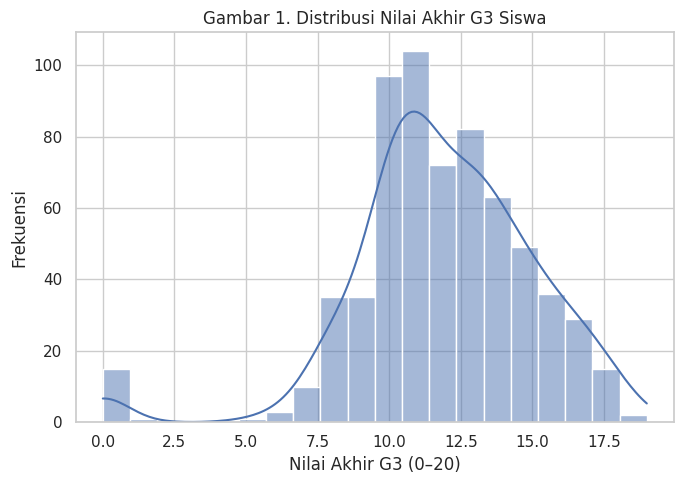

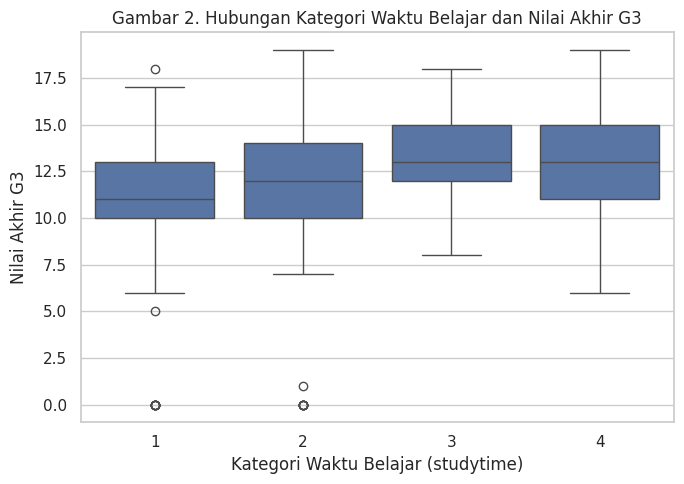

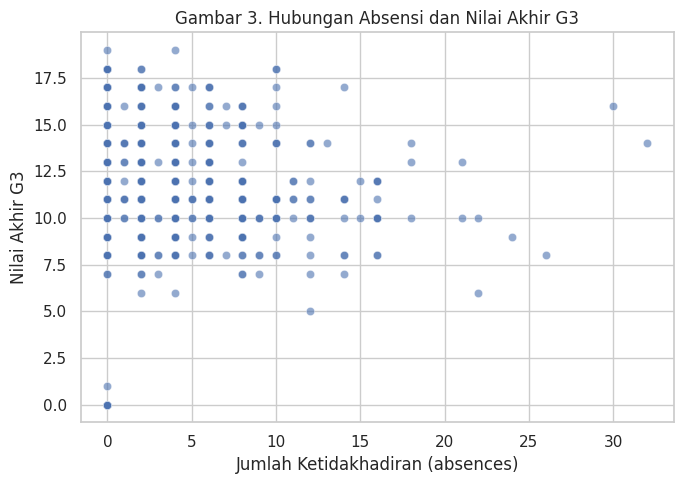

Fitur numerik   : ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
Fitur kategorik : ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic'] 

Ukuran data latih: (519, 30)
Ukuran data uji  : (130, 30) 

=== EVALUASI MODEL DASAR (REGRESI LINIER) ===
MSE  : 8.190
RMSE : 2.862
MAE  : 2.156
R²   : 0.160



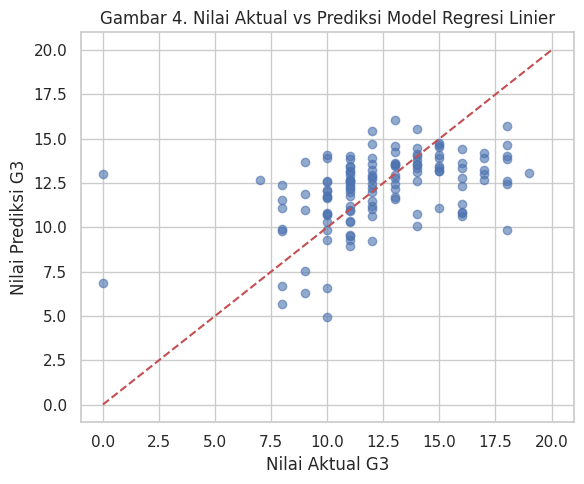

=== HASIL RANDOM SEARCH GRADIENT BOOSTING ===
Hyperparameter terbaik:
{'model__subsample': 1.0, 'model__n_estimators': 100, 'model__min_samples_split': 6, 'model__min_samples_leaf': 2, 'model__max_depth': 3, 'model__learning_rate': 0.05} 

Skor MSE rata-rata terbaik (negatif): -7.116

=== EVALUASI MODEL GRADIENT BOOSTING SETELAH TUNING ===
MSE  : 7.710
RMSE : 2.777
MAE  : 2.066
R²   : 0.209



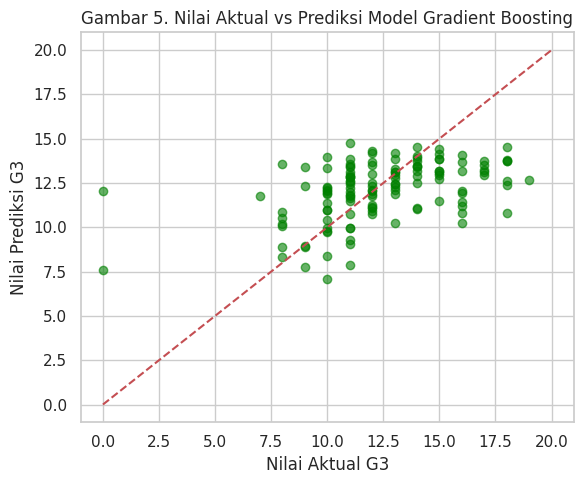

=== TABEL PERBANDINGAN KINERJA MODEL ===
                        Model       MSE      RMSE       MAE        R2
0              Regresi Linier  8.189784  2.861780  2.156382  0.160170
1  Gradient Boosting (Tuning)  7.710270  2.776737  2.065588  0.209342 



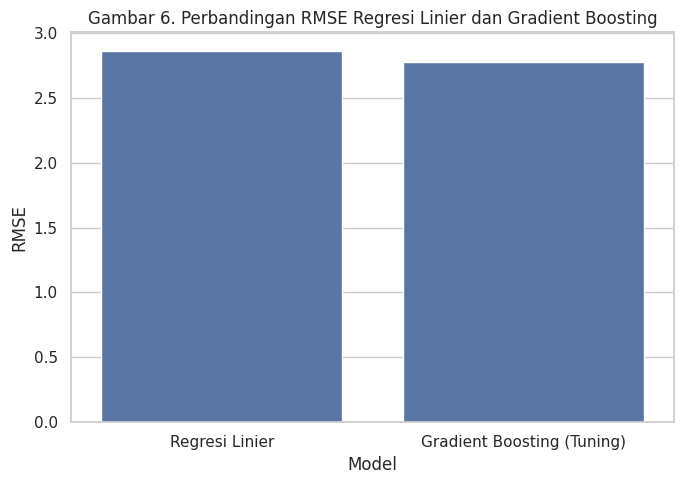

Beberapa fitur paling penting menurut Gradient Boosting:
failures        0.318550
absences        0.052497
Dalc            0.051144
school_GP       0.045725
Fedu            0.045155
higher_yes      0.036455
reason_other    0.035659
school_MS       0.035151
Medu            0.033795
goout           0.032586
dtype: float64 



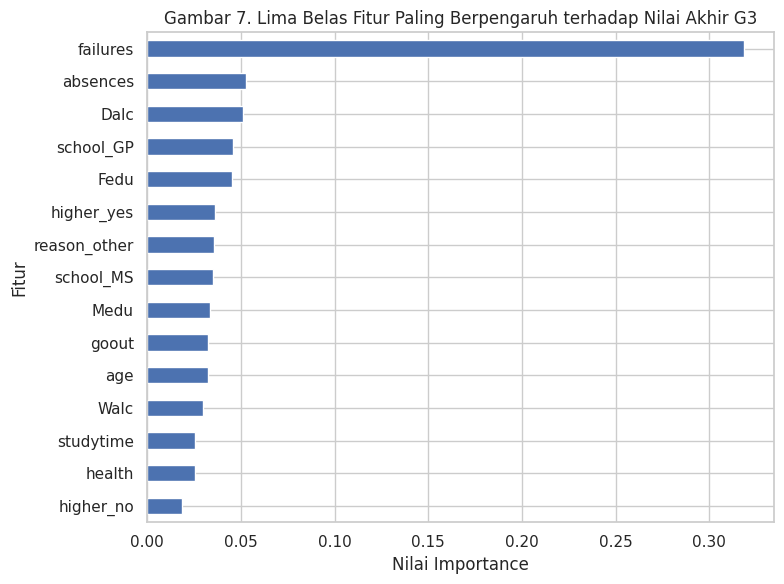

In [1]:
# ==========================================================
# Judul Program : Optimasi Prediksi Nilai Akhir Siswa dengan Gradient Boosting
# Buku         : Praktikum Data Science dan Machine Learning Berbasis Python dan UCI Repository
# Studi Kasus  : Student Performance – Prediksi Nilai G3
# Fokus        : Perbandingan Model Dasar (Regresi Linier) dan Gradient Boosting dengan Hyperparameter Tuning
# Dataset      : Student Performance – UCI Machine Learning Repository (ID: 320)
# UCI Link     : https://archive.ics.uci.edu/dataset/320/student+performance
# Repo         : https://github.com/datacentertugaskuliah-coder/PraktikumDS.git
# Lingkungan   : Google Colab
# ==========================================================

# Instalasi pustaka untuk akses dataset UCI
!pip install ucimlrepo -q

# Tahap 1 – Import pustaka
import pandas as pd
import numpy as np

from ucimlrepo import fetch_ucirepo

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.0)
np.random.seed(42)

# ==========================================================
# Tahap 2 – Mengambil dataset Student Performance dari UCI
# ==========================================================

student = fetch_ucirepo(id=320)

# Fitur dan target
X_asli = student.data.features.copy()
y_all = student.data.targets.copy()

print("=== METADATA DATASET STUDENT PERFORMANCE ===")
print(student.metadata, "\n")

print("=== INFORMASI VARIABEL (CONTOH) ===")
print(student.variables.head(), "\n")

print("Nama kolom pada bagian target:")
print(y_all.columns, "\n")

# Nilai akhir siswa biasanya berada pada kolom 'G3'
if "G3" in y_all.columns:
    y = y_all["G3"]
else:
    y = y_all.iloc[:, 0]
    print("Peringatan: Kolom 'G3' tidak ditemukan, menggunakan kolom target pertama.\n")

df = X_asli.copy()
df["G3"] = y

print("Lima baris pertama data:")
print(df.head(), "\n")

print("Ukuran data (baris, kolom):", df.shape, "\n")

print("Statistik deskriptif nilai akhir (G3):")
print(df["G3"].describe(), "\n")

# ==========================================================
# Tahap 3 – Eksplorasi dan visualisasi awal
# ==========================================================

# Gambar 1 – Distribusi nilai akhir G3
plt.figure(figsize=(7, 5))
sns.histplot(df["G3"], bins=20, kde=True)
plt.title("Gambar 1. Distribusi Nilai Akhir G3 Siswa")
plt.xlabel("Nilai Akhir G3 (0–20)")
plt.ylabel("Frekuensi")
plt.tight_layout()
plt.show()

# Gambar 2 – Hubungan jam belajar (studytime) dan G3 (jika ada)
if "studytime" in df.columns:
    plt.figure(figsize=(7, 5))
    sns.boxplot(x="studytime", y="G3", data=df)
    plt.title("Gambar 2. Hubungan Kategori Waktu Belajar dan Nilai Akhir G3")
    plt.xlabel("Kategori Waktu Belajar (studytime)")
    plt.ylabel("Nilai Akhir G3")
    plt.tight_layout()
    plt.show()

# Gambar 3 – Hubungan absensi dan G3 (jika ada)
if "absences" in df.columns:
    plt.figure(figsize=(7, 5))
    sns.scatterplot(x="absences", y="G3", data=df, alpha=0.6)
    plt.title("Gambar 3. Hubungan Absensi dan Nilai Akhir G3")
    plt.xlabel("Jumlah Ketidakhadiran (absences)")
    plt.ylabel("Nilai Akhir G3")
    plt.tight_layout()
    plt.show()

# ==========================================================
# Tahap 4 – Menyiapkan fitur dan pemisahan latih–uji
# ==========================================================

X = X_asli
target = y

fitur_numerik = X.select_dtypes(include=["int64", "float64"]).columns
fitur_kategorik = X.select_dtypes(include=["object"]).columns

print("Fitur numerik   :", list(fitur_numerik))
print("Fitur kategorik :", list(fitur_kategorik), "\n")

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), fitur_kategorik),
        ("num", "passthrough", fitur_numerik),
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    target,
    test_size=0.2,
    random_state=42
)

print("Ukuran data latih:", X_train.shape)
print("Ukuran data uji  :", X_test.shape, "\n")

# ==========================================================
# Tahap 5 – Model dasar: Regresi Linier (baseline)
# ==========================================================

baseline_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", LinearRegression())
    ]
)

baseline_pipeline.fit(X_train, y_train)
y_pred_baseline = baseline_pipeline.predict(X_test)

mse_baseline = mean_squared_error(y_test, y_pred_baseline)
rmse_baseline = np.sqrt(mse_baseline)
mae_baseline = mean_absolute_error(y_test, y_pred_baseline)
r2_baseline = r2_score(y_test, y_pred_baseline)

print("=== EVALUASI MODEL DASAR (REGRESI LINIER) ===")
print(f"MSE  : {mse_baseline:.3f}")
print(f"RMSE : {rmse_baseline:.3f}")
print(f"MAE  : {mae_baseline:.3f}")
print(f"R²   : {r2_baseline:.3f}\n")

# Gambar 4 – Scatter nilai aktual vs prediksi model dasar
plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred_baseline, alpha=0.6)
plt.plot([0, 20], [0, 20], "r--")
plt.title("Gambar 4. Nilai Aktual vs Prediksi Model Regresi Linier")
plt.xlabel("Nilai Aktual G3")
plt.ylabel("Nilai Prediksi G3")
plt.tight_layout()
plt.show()

# ==========================================================
# Tahap 6 – Model Gradient Boosting dengan Hyperparameter Tuning
# ==========================================================

gbr = GradientBoostingRegressor(random_state=42)

param_distribusi = {
    "model__n_estimators": [100, 200, 300],
    "model__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "model__max_depth": [2, 3, 4],
    "model__subsample": [0.8, 1.0],
    "model__min_samples_split": [2, 4, 6],
    "model__min_samples_leaf": [1, 2, 3]
}

gbr_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", gbr)
    ]
)

random_search = RandomizedSearchCV(
    estimator=gbr_pipeline,
    param_distributions=param_distribusi,
    n_iter=20,
    scoring="neg_mean_squared_error",
    cv=5,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("=== HASIL RANDOM SEARCH GRADIENT BOOSTING ===")
print("Hyperparameter terbaik:")
print(random_search.best_params_, "\n")
print(f"Skor MSE rata-rata terbaik (negatif): {random_search.best_score_:.3f}\n")

# ==========================================================
# Tahap 7 – Evaluasi model Gradient Boosting terbaik
# ==========================================================

best_gbr = random_search.best_estimator_
y_pred_gbr = best_gbr.predict(X_test)

mse_gbr = mean_squared_error(y_test, y_pred_gbr)
rmse_gbr = np.sqrt(mse_gbr)
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)

print("=== EVALUASI MODEL GRADIENT BOOSTING SETELAH TUNING ===")
print(f"MSE  : {mse_gbr:.3f}")
print(f"RMSE : {rmse_gbr:.3f}")
print(f"MAE  : {mae_gbr:.3f}")
print(f"R²   : {r2_gbr:.3f}\n")

# Gambar 5 – Scatter nilai aktual vs prediksi model Gradient Boosting
plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred_gbr, alpha=0.6, color="green")
plt.plot([0, 20], [0, 20], "r--")
plt.title("Gambar 5. Nilai Aktual vs Prediksi Model Gradient Boosting")
plt.xlabel("Nilai Aktual G3")
plt.ylabel("Nilai Prediksi G3")
plt.tight_layout()
plt.show()

# ==========================================================
# Tahap 8 – Perbandingan kinerja model
# ==========================================================

tabel_perbandingan = pd.DataFrame({
    "Model": ["Regresi Linier", "Gradient Boosting (Tuning)"],
    "MSE": [mse_baseline, mse_gbr],
    "RMSE": [rmse_baseline, rmse_gbr],
    "MAE": [mae_baseline, mae_gbr],
    "R2": [r2_baseline, r2_gbr]
})

print("=== TABEL PERBANDINGAN KINERJA MODEL ===")
print(tabel_perbandingan, "\n")

# Gambar 6 – Diagram batang perbandingan RMSE
plt.figure(figsize=(7, 5))
sns.barplot(
    data=tabel_perbandingan,
    x="Model",
    y="RMSE"
)
plt.title("Gambar 6. Perbandingan RMSE Regresi Linier dan Gradient Boosting")
plt.xlabel("Model")
plt.ylabel("RMSE")
plt.tight_layout()
plt.show()

# ==========================================================
# Tahap 9 – Analisis pentingnya fitur pada model Gradient Boosting
# ==========================================================

# Mengambil nama fitur setelah transformasi (One Hot + numerik)
preproses_terlatih = best_gbr.named_steps["preprocess"]
ohe = preproses_terlatih.named_transformers_["cat"]
nama_fitur_kat = ohe.get_feature_names_out(fitur_kategorik)
nama_fitur_num = fitur_numerik
nama_fitur_lengkap = np.concatenate([nama_fitur_kat, nama_fitur_num])

gbr_terlatih = best_gbr.named_steps["model"]
importance = pd.Series(gbr_terlatih.feature_importances_, index=nama_fitur_lengkap)
importance_urut = importance.sort_values(ascending=True)

print("Beberapa fitur paling penting menurut Gradient Boosting:")
print(importance_urut.sort_values(ascending=False).head(10), "\n")

# Gambar 7 – Diagram batang fitur paling penting
plt.figure(figsize=(8, 6))
importance_urut.tail(15).plot(kind="barh")
plt.title("Gambar 7. Lima Belas Fitur Paling Berpengaruh terhadap Nilai Akhir G3")
plt.xlabel("Nilai Importance")
plt.ylabel("Fitur")
plt.tight_layout()
plt.show()
